In [1]:
import torch
from pathlib import Path
import numpy as np
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

In [2]:
plt.style.use('model/lhcb.mplstyle')

In [3]:
#from model.models import AltCNN4Layer_D35_sp as Model
from model.models_mds_G_simon import AllCNN8Layer_Ca_Two_KDE_withPcnn as Model

from model.collectdata import collect_data, collect_truth
from model.collectdata_poca_KDE import collect_data_poca

from model.plots import plot_truth_vs_predict
from model.efficiency import efficiency, ValueSet, pv_locations, exact_efficiency
from model.efficiency_res import efficiency_res, ValueSet_res, pv_locations_res, get_resolution, get_nTracks_sorted, get_PVs_label
from model.training import select_gpu
from model.core import modernize_state

#### Device configuration

In [4]:
# device = select_gpu(2)
device = torch.device("cpu")

#### Load a dataset

In [5]:
valfile_ToyMC = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.h5')
valfile_FullMC = Path('/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5')
'''
WARNING ::: The data type of pv_HLT1CPU_MinBiasMagDown_14Nov.h5 and Oct03_20K_val.h5 
            files are different for some variables: i.e. 
           
'''
truth_ToyMC = collect_truth(valfile_ToyMC)
truth_FullMC = collect_truth(valfile_FullMC)

truth_FullMC_svs = collect_truth(valfile_FullMC, pvs=False)

print('-'*100)           
warn_msg = '\nWARNING ::: The data type of pv_HLT1CPU_MinBiasMagDown_14Nov.h5 and Oct03_20K_val.h5 \nfiles are different for some variables: i.e.\n'
print(warn_msg)           
print('Toy  MC true z:',type(truth_ToyMC.z[0][0]))
print('Full MC true z:',type(truth_FullMC.z[0][0]))

warn_msg = '\nThis causes an issue when calling some of the numba functions in model.efficiency_res.py\n'
print(warn_msg)           
print('-'*100)           


Loaded /share/lazy/schreihf/PvFinder/Oct03_20K_val.h5 in 0.3661 s
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 0.2387 s
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 0.3008 s
----------------------------------------------------------------------------------------------------

files are different for some variables: i.e.

Toy  MC true z: <class 'numpy.float32'>
Full MC true z: <class 'numpy.float64'>

This causes an issue when calling some of the numba functions in model.efficiency_res.py

----------------------------------------------------------------------------------------------------


In [6]:
'''
valfile_ToyMC does not have the necessary info to use collect_data_poca for the moment
'''

#validation_ToyMC = collect_data_poca(valfile_ToyMC,
#                                     batch_size=1,
#                                     device=device,
#                                     slice=slice(20000),
#                                     masking=True, shuffle=False,
#                                     load_XandXsq=False,
#                                     load_A_and_B = True,
#                                     load_xy=True)
                
validation_FullMC = collect_data_poca(valfile_FullMC,
                                      batch_size=1,
                                      device=device,
                                      slice=slice(20000),
                                      masking=False, shuffle=False,
                                      load_XandXsq=False,
                                      load_A_and_B = True,
                                      load_xy=True)

validation_FullMC_mask = collect_data_poca(valfile_FullMC,
                                      batch_size=1,
                                      device=device,
                                      slice=slice(20000),
                                      masking=True, shuffle=False,
                                      load_XandXsq=False,
                                      load_A_and_B = True,
                                      load_xy=True)
                                                    

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 17.12 s
Constructing 20000 event dataset took 0.2488 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 19.28 s
Constructing 20000 event dataset took 0.2595 s


In [7]:
model = Model().to(device)

#### Load the model weights

Modernizing old style models if needed.

In [8]:
model_dict = model.state_dict()
dict_name = 'ML/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0_final.pyt'
pretrained_dict = torch.load(dict_name)
model_dict.update(pretrained_dict) 
model.load_state_dict(pretrained_dict,strict=False)
model.eval()

AllCNN8Layer_Ca_Two_KDE_withPcnn(
  (softplus): Softplus(beta=1, threshold=20)
  (leaky): LeakyReLU(negative_slope=0.01)
  (relu): LeakyReLU(negative_slope=0.0)
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=F

In [9]:
#del state['fc1.weight'], state['fc1.bias']

ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        # fixing parameters
        param.requires_grad = False 
  ct += 1

ct, child =  0    Softplus(beta=1, threshold=20)
ct, child =  1    LeakyReLU(negative_slope=0.01)
ct, child =  2    LeakyReLU(negative_slope=0.0)
ct, child =  3    Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  4    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  5    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  6    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  7    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  8    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  9    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  10    Dropout(p=0.15, inplace=False)
ct, child =  11    Dropout(p=0.15, inplace=False)
ct, child =  12    Dropout(p=0.15, inplace=False)
ct, child =  13    Dropout(p=0.15, inplace=False)
ct, child =  14    Dropout(p=0.15, inplace=False)
ct, child =  15    Dropout(p=0.15, inplace=False)
ct,

#### Compute the model and move results to Numpy

In [10]:
%%time
with torch.no_grad():
#    outputs_ToyMC = model(validation_ToyMC.dataset.tensors[0]).cpu().numpy()
#    labels_ToyMC = validation_ToyMC.dataset.tensors[1].cpu().numpy()

    outputs_FullMC = model(validation_FullMC.dataset.tensors[0]).cpu().numpy()
    labels_FullMC = validation_FullMC.dataset.tensors[1].cpu().numpy() 
    
    outputs_FullMC_mask = model(validation_FullMC_mask.dataset.tensors[0]).cpu().numpy()
    labels_FullMC_mask = validation_FullMC_mask.dataset.tensors[1].cpu().numpy()    

x0 =  tensor([[2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [7.2615e-29, 3.7873e-31, 1.2248e-33,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        ...,
        [4.4202e-28, 3.1779e-30, 1.6454e-32,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.7596e-29, 1.1924e-31, 3.0095e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17]])
x1 =  tensor([[ 0.1092,  0.1095,  0.1098,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.0513,  0.0315,  0.0087,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.1092,  0.1095,  0.1098,  ..., -0.0398, -0.0137,  0.0103],
        ...,
        [ 0.0561,  0.0395,  0.0200,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.0057, -0.0218, -0.0536,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.1092,  0.1095,  0

In [11]:
#print(outputs_ToyMC[0])
print(outputs_FullMC[0])


[ 2.7715368e-30  1.1867729e-32  2.9475722e-35 ... -0.0000000e+00
 -0.0000000e+00  6.2731103e-19]


In [12]:
nTrcks_min = -1

true_PVs_z = truth_FullMC.z[18]
true_PVs_nTracks = truth_FullMC.n[18]

true_SVs_z = truth_FullMC_svs.z[18]
true_SVs_n = truth_FullMC_svs.n[18]
true_SVs_c = truth_FullMC_svs.cat[18]

sorted_true_SVs_z = sorted(true_SVs_z)
sorted_true_SVs_n = [i[1] for i in sorted( zip((true_SVs_z[true_SVs_n > nTrcks_min]), true_SVs_n[true_SVs_n > nTrcks_min]))]

print(sorted_true_SVs_z)
print(sorted_true_SVs_n)
print(true_SVs_c)

for i in sorted( zip((true_SVs_z[true_SVs_n > nTrcks_min]), true_SVs_n[true_SVs_n > nTrcks_min])):
    print((i[0]+100)*10,i[1])




[-213.9544, -81.5252, -6.8598, -6.8598, -6.8598, -6.8598, -6.8598, -6.8598, -6.778, -5.3782, -1.1001, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.6942, 1.9829, 1.9829, 3.0978, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 31.4656, 40.1074, 40.6587, 40.6587, 40.6587, 40.6587, 40.6587, 40.6587, 40.6587, 40.6587, 82.8925, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 88.0097, 107.6401, 108.4247, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 113.3134, 

In [13]:
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > nTrcks_min]), true_PVs_nTracks[true_PVs_nTracks > nTrcks_min]))]
filtered_and_sorted_true_PVs_z = [i[0] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > nTrcks_min]), true_PVs_nTracks[true_PVs_nTracks > nTrcks_min]))]
filtered_and_sorted_true_PVs_z_bins = [((i+100)*10) for i in filtered_and_sorted_true_PVs_z]
filtered_and_sorted_true_SVs_z_bins = [((i+100)*10) for i in sorted(true_SVs_z)]

print(truth_FullMC.cat[18])
print(true_PVs_nTracks)
print(true_PVs_z)
print(filtered_and_sorted_true_PVs_nTracks)
print(filtered_and_sorted_true_PVs_z)
print(filtered_and_sorted_true_PVs_z_bins)


[-1  1  1  1  0  1  1 -1  1 -1  1]
[ 0 12 54  9  3 52 22  0 22  0 52]
[  38.957   124.4326  113.3134   -6.8598   40.1074    1.6942   88.0097
 -103.0614   40.6587  107.5699   31.4656]
[0, 9, 52, 52, 0, 3, 22, 22, 0, 54, 12]
[-103.0614, -6.8598, 1.6942, 31.4656, 38.957, 40.1074, 40.6587, 88.0097, 107.5699, 113.3134, 124.4326]
[-30.61400000000006, 931.4019999999999, 1016.942, 1314.656, 1389.57, 1401.0739999999998, 1406.587, 1880.0970000000002, 2075.699, 2133.134, 2244.326]


In [14]:
for i in range(len(labels_FullMC_mask[18])):
    print(i,labels_FullMC_mask[18][i],labels_FullMC[18][i],outputs_FullMC_mask[18][i],outputs_FullMC[18][i])
print(truth_FullMC.n[18])



0 0.0 0.0 2.7715368e-30 2.7715368e-30
1 0.0 0.0 1.1867729e-32 1.1867729e-32
2 0.0 0.0 2.9475722e-35 2.9475722e-35
3 0.0 0.0 6.370643e-38 6.370643e-38
4 0.0 0.0 1.94928e-40 1.94928e-40
5 0.0 0.0 1.878e-42 1.878e-42
6 0.0 0.0 8.3e-44 8.3e-44
7 0.0 0.0 1.4e-44 1.4e-44
8 0.0 0.0 7e-45 7e-45
9 0.0 0.0 6e-45 6e-45
10 0.0 0.0 1e-45 1e-45
11 0.0 0.0 0.0 0.0
12 0.0 0.0 0.0 0.0
13 0.0 0.0 0.0 0.0
14 0.0 0.0 0.0 0.0
15 0.0 0.0 0.0 0.0
16 0.0 0.0 0.0 0.0
17 0.0 0.0 0.0 0.0
18 0.0 0.0 0.0 0.0
19 0.0 0.0 0.0 0.0
20 0.0 0.0 0.0 0.0
21 0.0 0.0 0.0 0.0
22 0.0 0.0 0.0 0.0
23 0.0 0.0 0.0 0.0
24 0.0 0.0 0.0 0.0
25 0.0 0.0 0.0 0.0
26 0.0 0.0 0.0 0.0
27 0.0 0.0 0.0 0.0
28 0.0 0.0 0.0 0.0
29 0.0 0.0 0.0 0.0
30 0.0 0.0 0.0 0.0
31 0.0 0.0 0.0 0.0
32 0.0 0.0 0.0 0.0
33 0.0 0.0 0.0 0.0
34 0.0 0.0 0.0 0.0
35 0.0 0.0 0.0 0.0
36 0.0 0.0 0.0 0.0
37 0.0 0.0 0.0 0.0
38 0.0 0.0 0.0 0.0
39 0.0 0.0 0.0 0.0
40 0.0 0.0 0.0 0.0
41 0.0 0.0 0.0 0.0
42 0.0 0.0 0.0 0.0
43 0.0 0.0 0.0 0.0
44 0.0 0.0 0.0 0.0
45 0.0 0.0 0.0 0.0
46

451 0.0 0.0 -0.0 -0.0
452 0.0 0.0 -0.0 -0.0
453 0.0 0.0 -0.0 -0.0
454 0.0 0.0 -0.0 -0.0
455 0.0 0.0 -0.0 -0.0
456 0.0 0.0 -0.0 -0.0
457 0.0 0.0 -0.0 -0.0
458 0.0 0.0 -0.0 -0.0
459 0.0 0.0 -0.0 -0.0
460 0.0 0.0 -0.0 -0.0
461 0.0 0.0 -0.0 -0.0
462 0.0 0.0 -0.0 -0.0
463 0.0 0.0 -0.0 -0.0
464 0.0 0.0 -0.0 -0.0
465 0.0 0.0 -0.0 -0.0
466 0.0 0.0 -0.0 -0.0
467 0.0 0.0 -0.0 -0.0
468 0.0 0.0 -0.0 -0.0
469 0.0 0.0 -0.0 -0.0
470 0.0 0.0 -0.0 -0.0
471 0.0 0.0 -0.0 -0.0
472 0.0 0.0 -0.0 -0.0
473 0.0 0.0 -0.0 -0.0
474 0.0 0.0 -0.0 -0.0
475 0.0 0.0 -0.0 -0.0
476 0.0 0.0 -0.0 -0.0
477 0.0 0.0 -0.0 -0.0
478 0.0 0.0 -0.0 -0.0
479 0.0 0.0 -0.0 -0.0
480 0.0 0.0 -0.0 -0.0
481 0.0 0.0 -0.0 -0.0
482 0.0 0.0 -0.0 -0.0
483 0.0 0.0 -0.0 -0.0
484 0.0 0.0 -0.0 -0.0
485 0.0 0.0 -0.0 -0.0
486 0.0 0.0 -0.0 -0.0
487 0.0 0.0 -0.0 -0.0
488 0.0 0.0 -0.0 -0.0
489 0.0 0.0 -0.0 -0.0
490 0.0 0.0 -0.0 -0.0
491 0.0 0.0 -0.0 -0.0
492 0.0 0.0 -0.0 -0.0
493 0.0 0.0 -0.0 -0.0
494 0.0 0.0 -0.0 -0.0
495 0.0 0.0 -0.0 -0.0
496 0.0 0.

1295 0.0 0.0 2.4176519e-09 2.4176519e-09
1296 0.0 0.0 4.488652e-14 4.488652e-14
1297 0.0 0.0 1.2201751e-29 1.2201751e-29
1298 0.0 0.0 8e-45 8e-45
1299 0.0 0.0 6.6706366e-32 6.6706366e-32
1300 0.0 0.0 1.7848819e-19 1.7848819e-19
1301 0.0 0.0 6.1235435e-12 6.1235435e-12
1302 0.0 0.0 1.5078305e-09 1.5078305e-09
1303 0.0 0.0 1.4719425e-11 1.4719425e-11
1304 0.0 0.0 1.2269186e-18 1.2269186e-18
1305 0.0 0.0 5.726743e-38 5.726743e-38
1306 0.0 0.0 0.0 0.0
1307 0.0 0.0 0.0 0.0
1308 0.0 0.0 4.2227144e-33 4.2227144e-33
1309 0.0 0.0 1.6428444e-17 1.6428444e-17
1310 0.0 0.0 4.6208832e-08 4.6208832e-08
1311 0.0 0.0 0.0013667864 0.0013667864
1312 0.00030493736 0.00030493736 0.22066726 0.22066726
1313 0.23352051 0.23352051 1.1807302 1.1807302
1314 2.4179688 2.4179688 1.950221 1.950221
1315 0.7363281 0.7363281 1.1403717 1.1403717
1316 0.0040130615 0.0040130615 0.40009248 0.40009248
1317 1.7881393e-07 1.7881393e-07 0.06808609 0.06808609
1318 0.0 0.0 0.020690458 0.020690458
1319 0.0 0.0 0.1386845 0.13868

1840 0.0 0.0 7.174806e-32 7.174806e-32
1841 0.0 0.0 1.7864182e-33 1.7864182e-33
1842 0.0 0.0 1.6433715e-32 1.6433715e-32
1843 0.0 0.0 1.8215778e-29 1.8215778e-29
1844 0.0 0.0 6.821618e-27 6.821618e-27
1845 0.0 0.0 1.7056732e-25 1.7056732e-25
1846 0.0 0.0 1.198728e-25 1.198728e-25
1847 0.0 0.0 1.11429546e-26 1.11429546e-26
1848 0.0 0.0 8.3067916e-27 8.3067916e-27
1849 0.0 0.0 3.8255844e-27 3.8255844e-27
1850 0.0 0.0 3.5635053e-26 3.5635053e-26
1851 0.0 0.0 1.4329597e-20 1.4329597e-20
1852 0.0 0.0 2.4864957e-15 2.4864957e-15
1853 0.0 0.0 7.964347e-14 7.964347e-14
1854 0.0 0.0 1.0706258e-15 1.0706258e-15
1855 0.0 0.0 1.1815289e-24 1.1815289e-24
1856 0.0 0.0 9.1e-44 9.1e-44
1857 0.0 0.0 0.0 0.0
1858 0.0 0.0 3.680865e-38 3.680865e-38
1859 0.0 0.0 5.244784e-25 5.244784e-25
1860 0.0 0.0 3.610806e-18 3.610806e-18
1861 0.0 0.0 1.1250292e-15 1.1250292e-15
1862 0.0 0.0 5.1308777e-16 5.1308777e-16
1863 0.0 0.0 1.765634e-18 1.765634e-18
1864 0.0 0.0 1.7529277e-20 1.7529277e-20
1865 0.0 0.0 7.86968e

2395 0.0 0.0 -0.0 -0.0
2396 0.0 0.0 -0.0 -0.0
2397 0.0 0.0 -0.0 -0.0
2398 0.0 0.0 -0.0 -0.0
2399 0.0 0.0 -0.0 -0.0
2400 0.0 0.0 -0.0 -0.0
2401 0.0 0.0 -0.0 -0.0
2402 0.0 0.0 -0.0 -0.0
2403 0.0 0.0 -0.0 -0.0
2404 0.0 0.0 -0.0 -0.0
2405 0.0 0.0 -0.0 -0.0
2406 0.0 0.0 -0.0 -0.0
2407 0.0 0.0 -0.0 -0.0
2408 0.0 0.0 -0.0 -0.0
2409 0.0 0.0 -0.0 -0.0
2410 0.0 0.0 -0.0 -0.0
2411 0.0 0.0 -0.0 -0.0
2412 0.0 0.0 -0.0 -0.0
2413 0.0 0.0 -0.0 -0.0
2414 0.0 0.0 -0.0 -0.0
2415 0.0 0.0 -0.0 -0.0
2416 0.0 0.0 -0.0 -0.0
2417 0.0 0.0 -0.0 -0.0
2418 0.0 0.0 -0.0 -0.0
2419 0.0 0.0 -0.0 -0.0
2420 0.0 0.0 -0.0 -0.0
2421 0.0 0.0 -0.0 -0.0
2422 0.0 0.0 -0.0 -0.0
2423 0.0 0.0 -0.0 -0.0
2424 0.0 0.0 -0.0 -0.0
2425 0.0 0.0 -0.0 -0.0
2426 0.0 0.0 -0.0 -0.0
2427 0.0 0.0 -0.0 -0.0
2428 0.0 0.0 -0.0 -0.0
2429 0.0 0.0 -0.0 -0.0
2430 0.0 0.0 -0.0 -0.0
2431 0.0 0.0 -0.0 -0.0
2432 0.0 0.0 -0.0 -0.0
2433 0.0 0.0 -0.0 -0.0
2434 0.0 0.0 -0.0 -0.0
2435 0.0 0.0 -0.0 -0.0
2436 0.0 0.0 -0.0 -0.0
2437 0.0 0.0 -0.0 -0.0
2438 0.0 0.

2994 0.0 0.0 0.0 0.0
2995 0.0 0.0 0.0 0.0
2996 0.0 0.0 0.0 0.0
2997 0.0 0.0 0.0 0.0
2998 0.0 0.0 0.0 0.0
2999 0.0 0.0 0.0 0.0
3000 0.0 0.0 0.0 0.0
3001 0.0 0.0 0.0 0.0
3002 0.0 0.0 0.0 0.0
3003 0.0 0.0 0.0 0.0
3004 0.0 0.0 0.0 0.0
3005 0.0 0.0 0.0 0.0
3006 0.0 0.0 0.0 0.0
3007 0.0 0.0 0.0 0.0
3008 0.0 0.0 0.0 0.0
3009 0.0 0.0 0.0 0.0
3010 0.0 0.0 0.0 0.0
3011 0.0 0.0 0.0 0.0
3012 0.0 0.0 0.0 0.0
3013 0.0 0.0 0.0 0.0
3014 0.0 0.0 0.0 0.0
3015 0.0 0.0 0.0 0.0
3016 0.0 0.0 0.0 0.0
3017 0.0 0.0 0.0 0.0
3018 0.0 0.0 0.0 0.0
3019 0.0 0.0 0.0 0.0
3020 0.0 0.0 0.0 0.0
3021 0.0 0.0 0.0 0.0
3022 0.0 0.0 0.0 0.0
3023 0.0 0.0 0.0 0.0
3024 0.0 0.0 0.0 0.0
3025 0.0 0.0 0.0 0.0
3026 0.0 0.0 0.0 0.0
3027 0.0 0.0 0.0 0.0
3028 0.0 0.0 0.0 0.0
3029 0.0 0.0 0.0 0.0
3030 0.0 0.0 0.0 0.0
3031 0.0 0.0 0.0 0.0
3032 0.0 0.0 0.0 0.0
3033 0.0 0.0 0.0 0.0
3034 0.0 0.0 0.0 0.0
3035 0.0 0.0 0.0 0.0
3036 0.0 0.0 0.0 0.0
3037 0.0 0.0 0.0 0.0
3038 0.0 0.0 0.0 0.0
3039 0.0 0.0 0.0 0.0
3040 0.0 0.0 0.0 0.0
3041 0.0 0.0 

3694 0.0 0.0 0.0 0.0
3695 0.0 0.0 0.0 0.0
3696 0.0 0.0 0.0 0.0
3697 0.0 0.0 0.0 0.0
3698 0.0 0.0 0.0 0.0
3699 0.0 0.0 0.0 0.0
3700 0.0 0.0 0.0 0.0
3701 0.0 0.0 0.0 0.0
3702 0.0 0.0 0.0 0.0
3703 0.0 0.0 0.0 0.0
3704 0.0 0.0 0.0 0.0
3705 0.0 0.0 0.0 0.0
3706 0.0 0.0 0.0 0.0
3707 0.0 0.0 0.0 0.0
3708 0.0 0.0 0.0 0.0
3709 0.0 0.0 0.0 0.0
3710 0.0 0.0 0.0 0.0
3711 0.0 0.0 0.0 0.0
3712 0.0 0.0 0.0 0.0
3713 0.0 0.0 0.0 0.0
3714 0.0 0.0 0.0 0.0
3715 0.0 0.0 0.0 0.0
3716 0.0 0.0 0.0 0.0
3717 0.0 0.0 0.0 0.0
3718 0.0 0.0 0.0 0.0
3719 0.0 0.0 0.0 0.0
3720 0.0 0.0 0.0 0.0
3721 0.0 0.0 0.0 0.0
3722 0.0 0.0 0.0 0.0
3723 0.0 0.0 0.0 0.0
3724 0.0 0.0 0.0 0.0
3725 0.0 0.0 0.0 0.0
3726 0.0 0.0 0.0 0.0
3727 0.0 0.0 0.0 0.0
3728 0.0 0.0 0.0 0.0
3729 0.0 0.0 0.0 0.0
3730 0.0 0.0 0.0 0.0
3731 0.0 0.0 0.0 0.0
3732 0.0 0.0 0.0 0.0
3733 0.0 0.0 0.0 0.0
3734 0.0 0.0 0.0 0.0
3735 0.0 0.0 0.0 0.0
3736 0.0 0.0 0.0 0.0
3737 0.0 0.0 0.0 0.0
3738 0.0 0.0 0.0 0.0
3739 0.0 0.0 0.0 0.0
3740 0.0 0.0 0.0 0.0
3741 0.0 0.0 

#### Compute the efficencies over the dataset

In [15]:
eff_settings_res_top = dict(
                        nsig_res = 5, # number of sigmas from original res(nTracks)
                        min_res = 10.0, # 
                        threshold = 0.06,
                        integral_threshold = 0.75,
                        min_width = 0, # bins
                        debug = 0,     # bins
                        )

eff_settings = dict(
    difference = 5., # bins
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

eff_settings_nodiff = eff_settings.copy()
del eff_settings_nodiff['difference']

In [16]:
%%time
total = ValueSet(0,0,0,0)
i=0
for label, output in zip(labels_FullMC, outputs_FullMC):
    total += efficiency(label, output, **eff_settings)
    if i<20:
        print(total)
    i+=1

Found 4 of 4, added 0 (eff 100.00%) (0.0 FP/event)
Found 11 of 11, added 0 (eff 100.00%) (0.0 FP/event)
Found 16 of 16, added 2 (eff 100.00%) (0.5 FP/event)
Found 19 of 19, added 3 (eff 100.00%) (0.6 FP/event)
Found 23 of 23, added 3 (eff 100.00%) (0.5 FP/event)
Found 27 of 27, added 3 (eff 100.00%) (0.429 FP/event)
Found 31 of 31, added 5 (eff 100.00%) (0.625 FP/event)
Found 34 of 34, added 5 (eff 100.00%) (0.556 FP/event)
Found 38 of 38, added 5 (eff 100.00%) (0.5 FP/event)
Found 45 of 45, added 5 (eff 100.00%) (0.455 FP/event)
Found 50 of 50, added 5 (eff 100.00%) (0.417 FP/event)
Found 59 of 59, added 5 (eff 100.00%) (0.385 FP/event)
Found 64 of 64, added 5 (eff 100.00%) (0.357 FP/event)
Found 70 of 70, added 5 (eff 100.00%) (0.333 FP/event)
Found 72 of 72, added 5 (eff 100.00%) (0.312 FP/event)
Found 79 of 79, added 5 (eff 100.00%) (0.294 FP/event)
Found 82 of 82, added 5 (eff 100.00%) (0.278 FP/event)
Found 91 of 91, added 5 (eff 100.00%) (0.263 FP/event)
Found 98 of 98, added 5 

In [17]:
print(total)
#print()
print(total.pretty())

Found 100657 of 102795, added 6214 (eff 97.92%) (0.311 FP/event)
Real PVs in validation set: 102,795
Successes: Either 100,657 or 100,227, depending on how you count.
Missed true PVs: 2,138
False positives: 6,214
Efficiency of detecting real PVs: 97.92%
False positive rate: 0.311


#### Some examples of the counting algorithm:

In [18]:
for i in range(2):
    result = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)
    print(format(i, '2'), result)

 0 Found 4 of 4, added 0 (eff 100.00%)
 1 Found 7 of 7, added 0 (eff 100.00%)


2
[648.7729999999999, 1145.556, 1529.288, 1584.044, 2144.137, 2278.877]
[13, 16, 26, 36, 41, 104]
3
[1407.809, 1483.2050000000002, 1985.5639999999999]
[13, 70, 19]
6
[80.84100000000007, 316.94100000000003, 936.953, 1463.835, 1576.376]
[8, 17, 100, 26, 31]
18
[931.4019999999999, 1016.942, 1314.656, 1406.587, 1880.0970000000002, 2133.134, 2244.326]
[9, 52, 52, 22, 22, 54, 12]
46
[368.88800000000003]
[17]
56
[76.79400000000001, 678.856, 902.735, 935.923, 986.549, 1103.9740000000002, 1174.429, 1406.063]
[74, 42, 86, 73, 24, 64, 7, 16]
65
[475.34999999999997, 761.106, 782.404, 886.596, 1033.0140000000001, 1528.311, 1639.228]
[27, 12, 32, 12, 35, 53, 96]
118
[-285.5529999999999, 424.377, 600.976, 651.8219999999999, 725.7130000000001, 1162.781, 1748.1950000000002, 1795.611]
[18, 35, 69, 10, 10, 46, 13, 28]
130
[862.0400000000001, 1004.24, 1653.8560000000002]
[62, 113, 122]
141
[-35.82499999999996, 322.70700000000005, 521.59, 1183.019, 1242.555, 1503.3029999999999, 2528.829]
[13, 24, 58, 75, 1

/home/sakar/pv-finder/notebooks/model/plots.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(18, 2))


421
[353.403, 913.48, 1201.75]
[24, 47, 28]
424
[602.646, 882.8430000000001, 1157.147, 1323.3529999999998, 1675.9019999999998]
[64, 23, 11, 24, 86]
432
[223.92600000000002, 396.157, 513.726, 1463.878, 1678.1369999999997]
[74, 6, 8, 76, 25]
447
[-149.867, 163.44099999999997, 1024.442, 2103.343, 2534.359]
[47, 40, 11, 16, 18]
454
[-828.1030000000001, 590.76, 758.437, 958.759, 1396.8600000000001, 1600.602, 1635.9109999999998, 1712.563]
[41, 15, 42, 124, 10, 13, 12, 27]
458
[204.36700000000002, 1158.775, 1253.998, 1272.114, 1722.554, 1740.429, 1839.4799999999998]
[26, 10, 26, 95, 5, 118, 39]
484
[-192.72400000000005, 388.761, 576.611, 620.212, 768.331, 1003.4090000000001, 1098.2259999999999, 1361.8129999999999, 1579.4409999999998, 1630.746]
[35, 31, 12, 17, 49, 17, 27, 79, 12, 52]
497
[-68.08300000000003, 1334.774, 1488.262, 1615.1080000000002, 1777.345, 1911.217, 1945.6619999999998]
[54, 78, 11, 24, 36, 13, 34]
498
[-614.7620000000001, -26.432999999999964, 656.182, 812.435, 865.913, 1308.

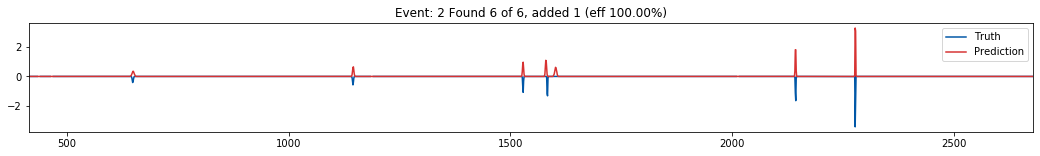

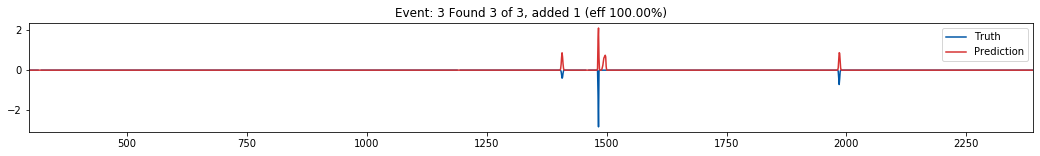

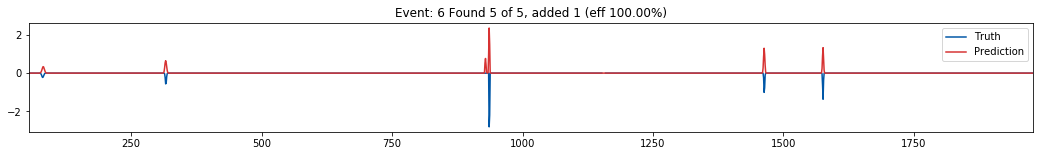

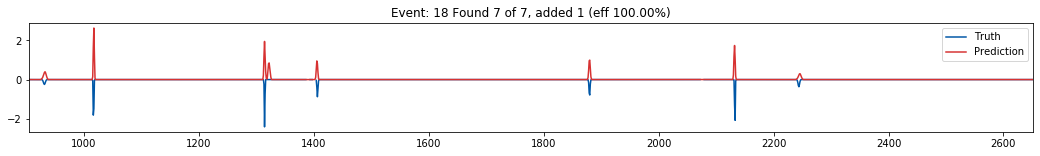

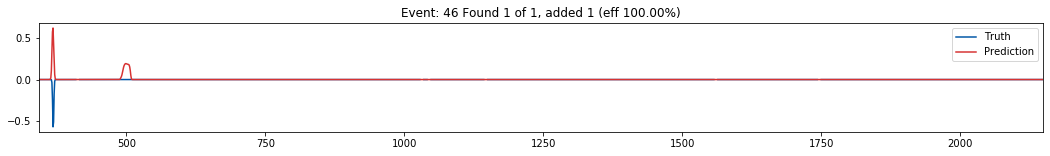

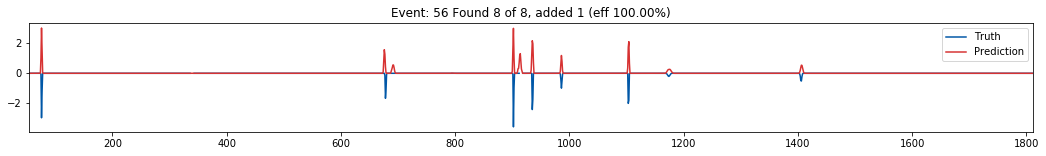

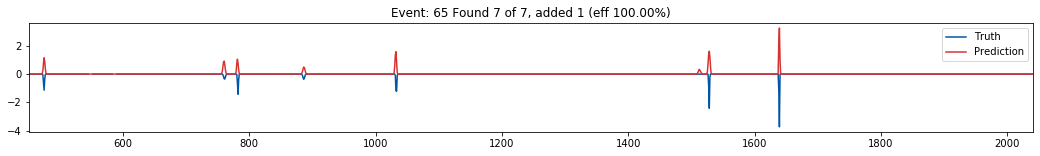

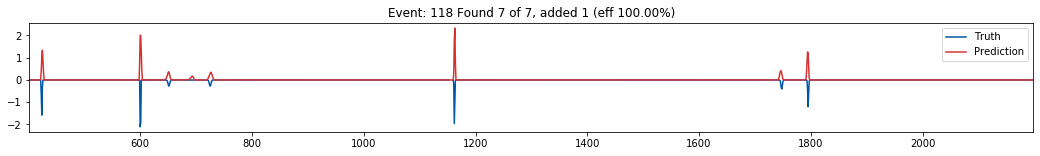

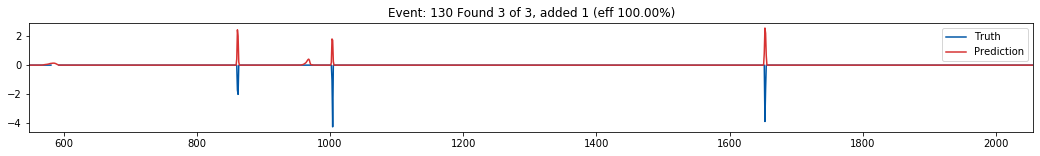

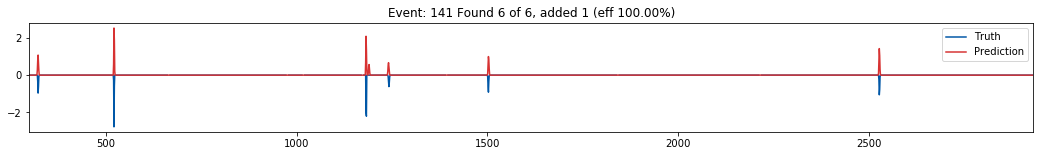

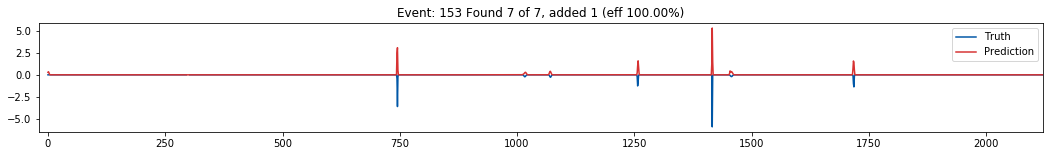

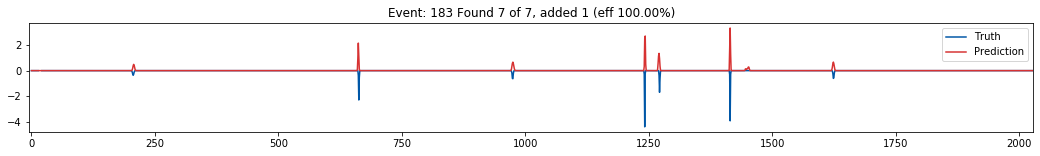

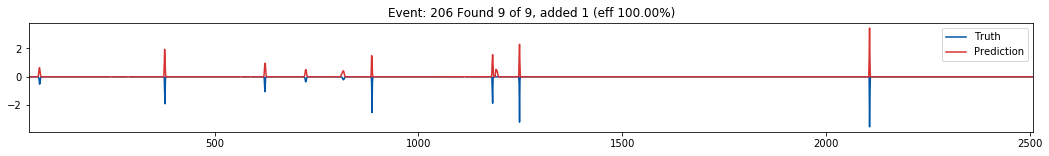

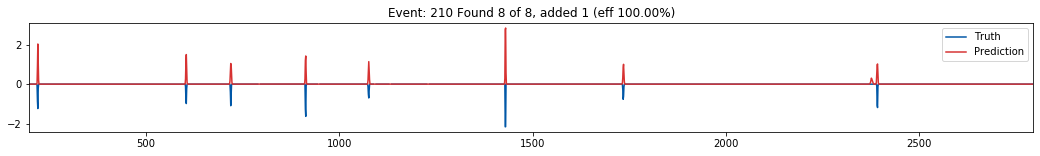

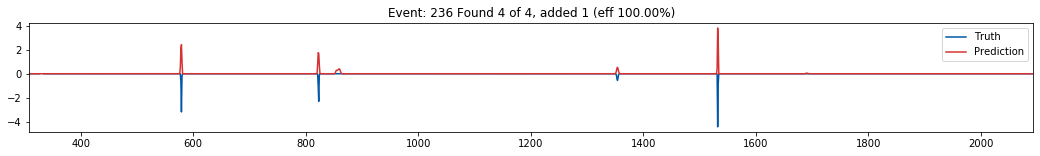

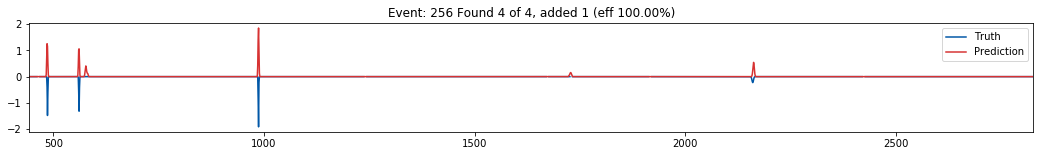

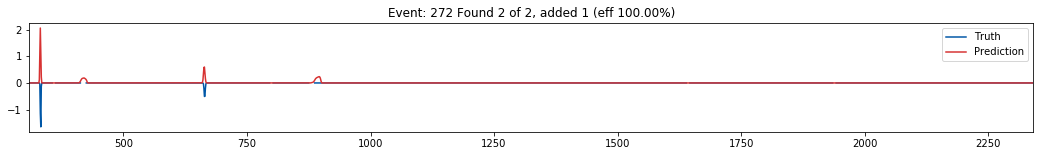

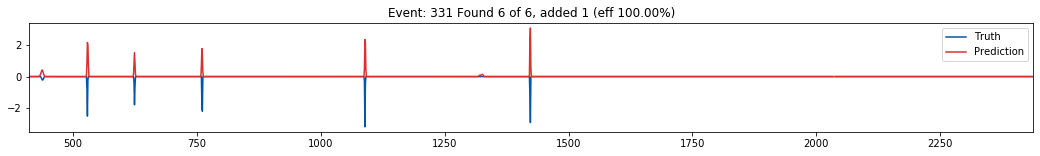

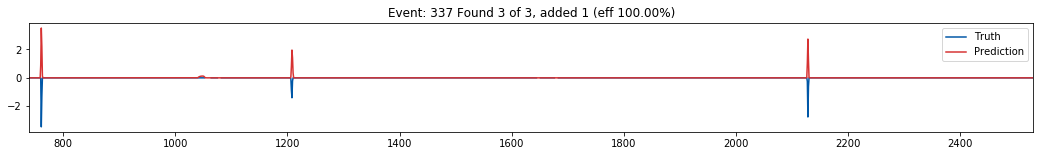

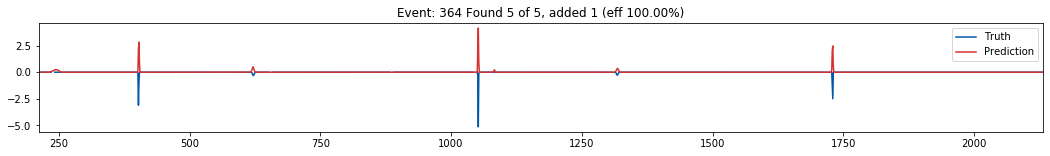

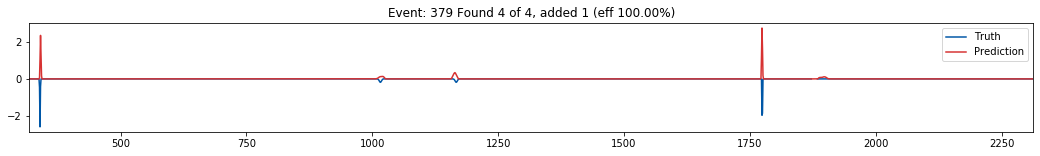

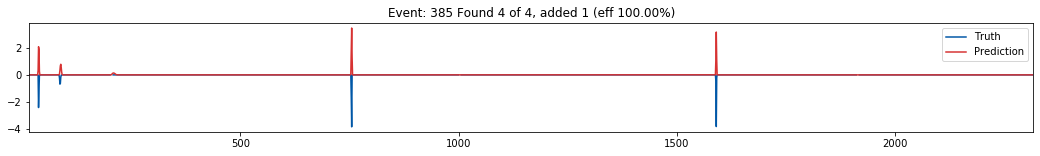

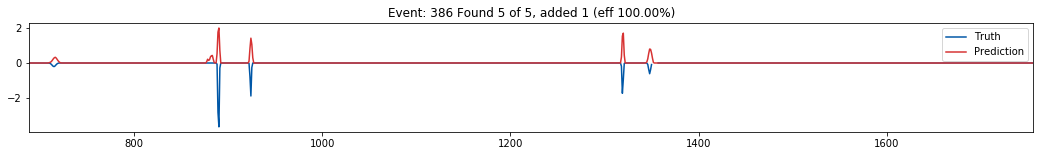

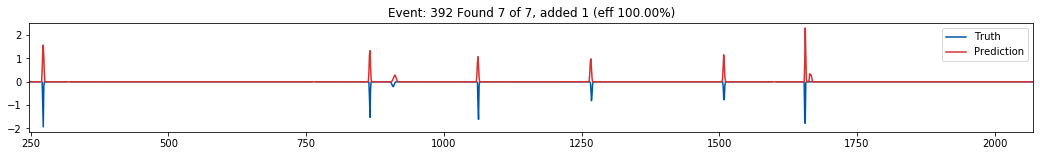

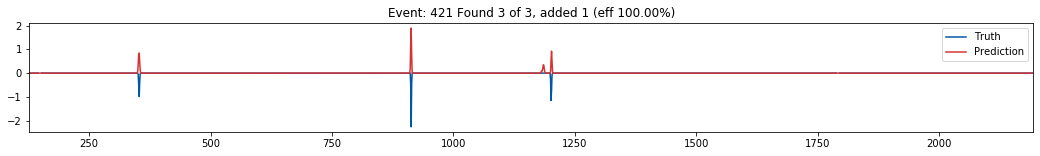

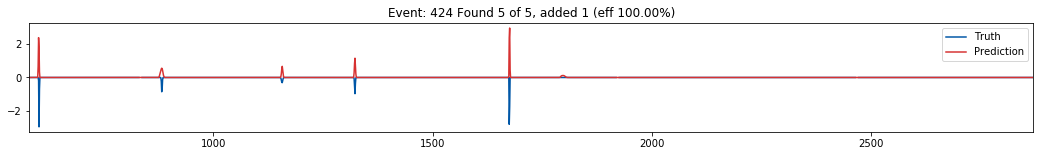

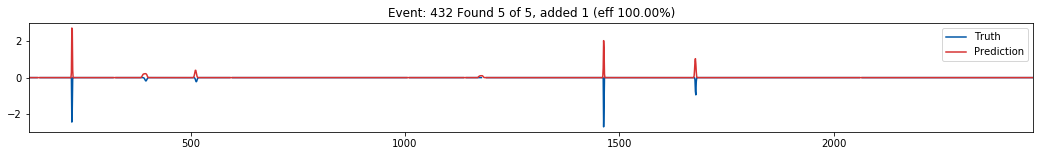

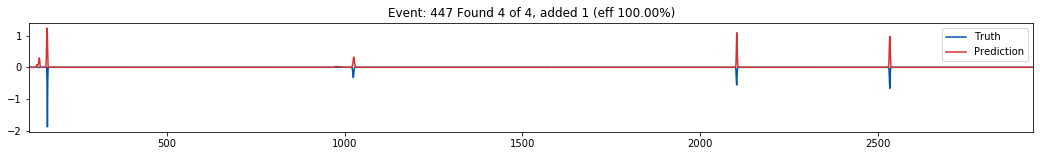

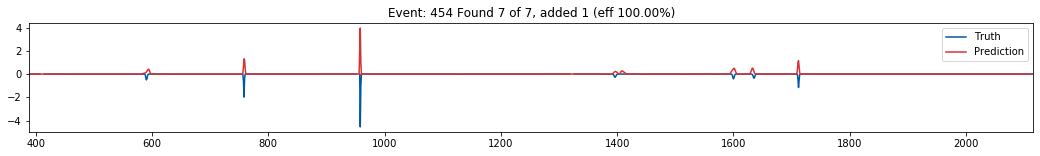

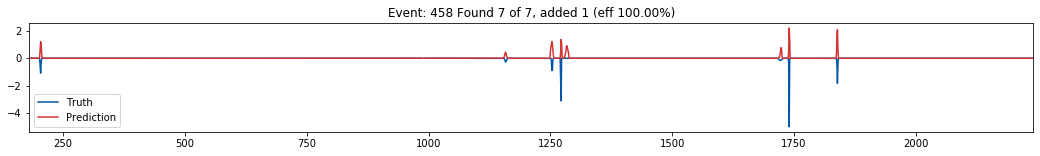

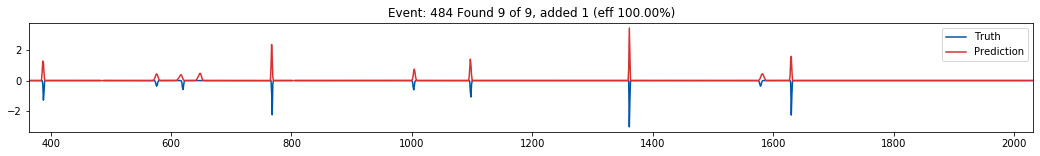

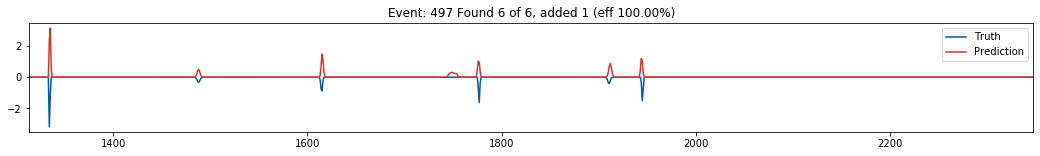

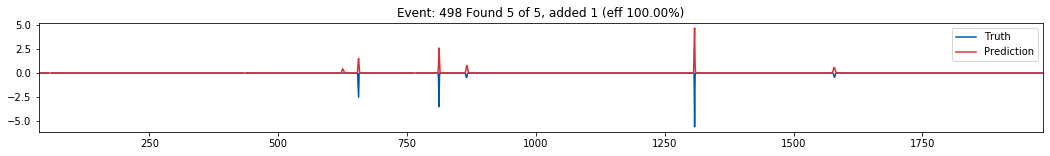

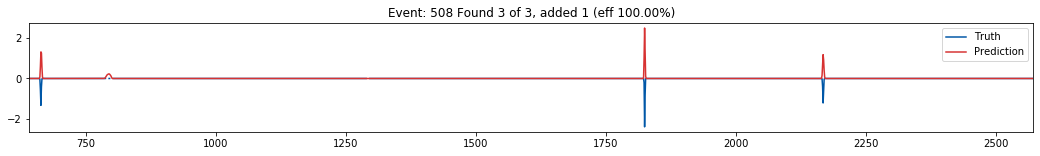

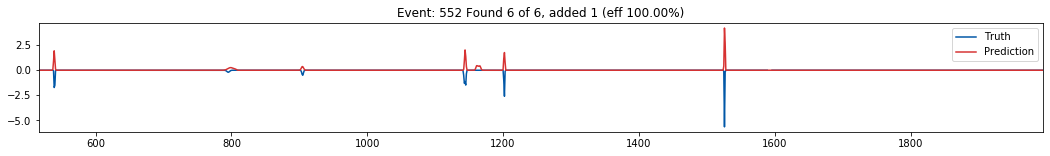

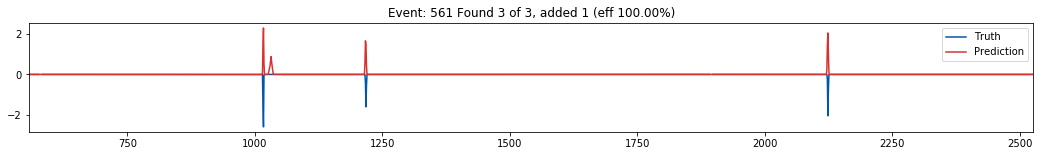

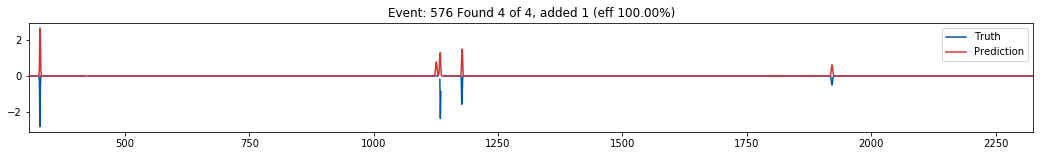

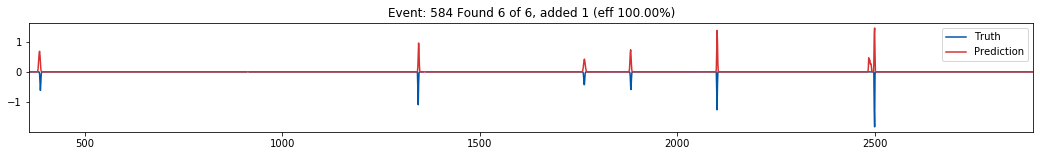

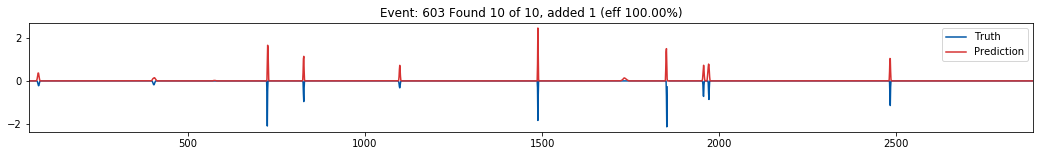

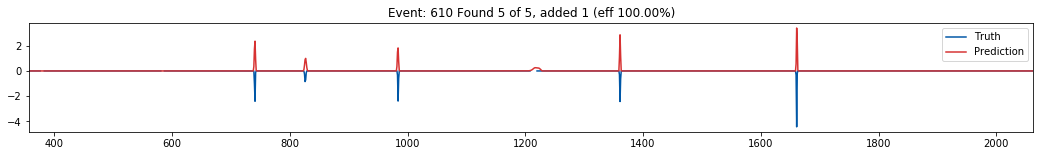

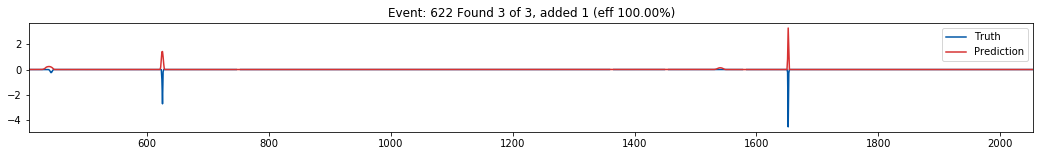

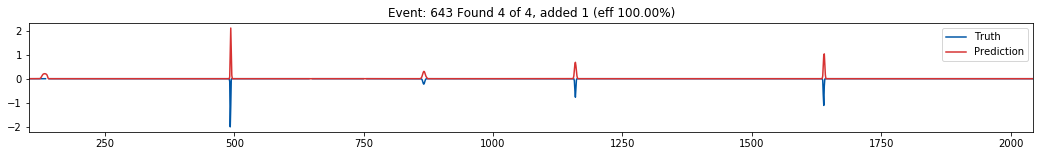

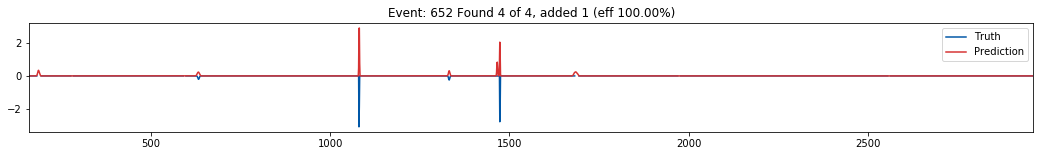

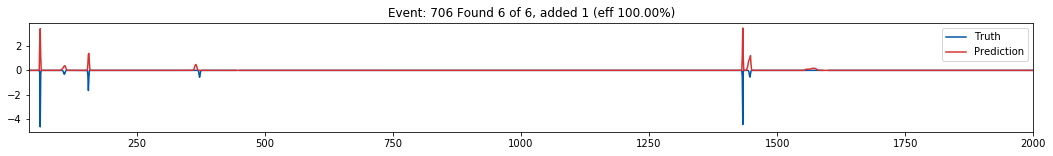

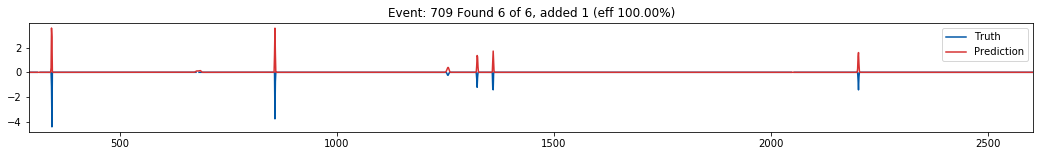

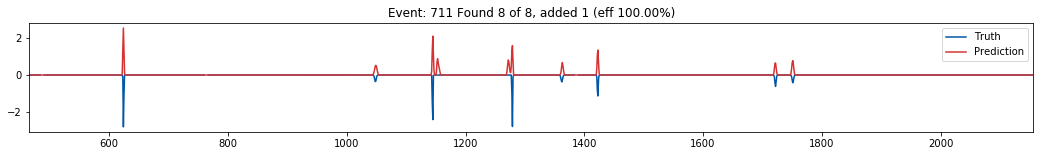

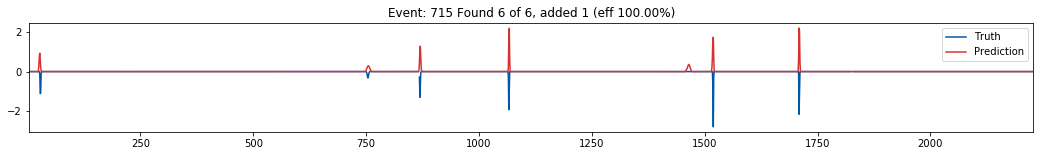

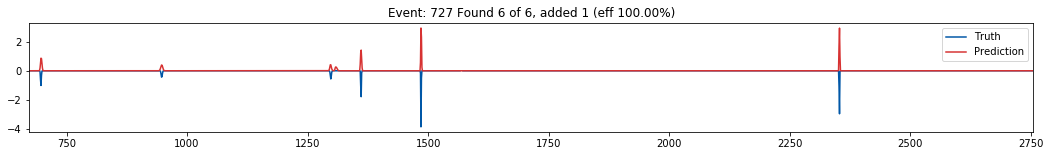

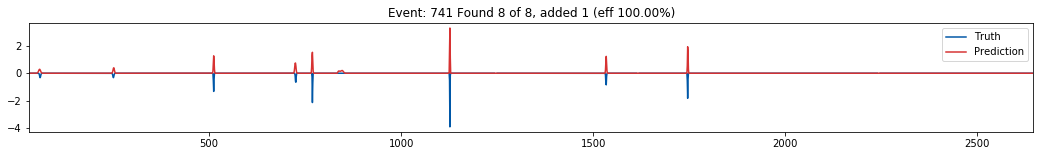

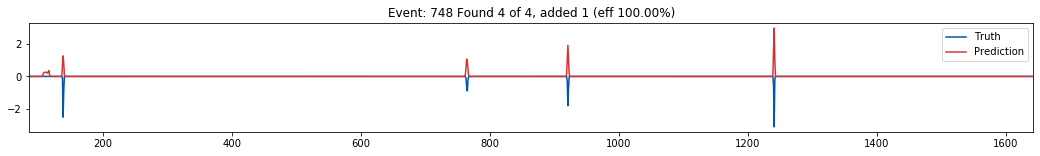

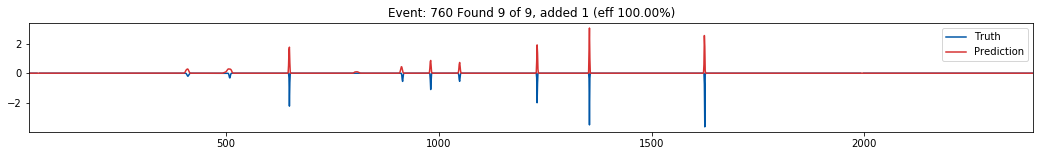

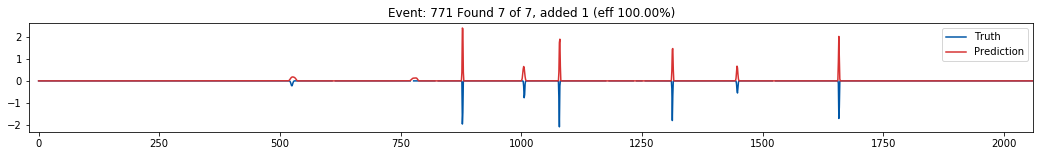

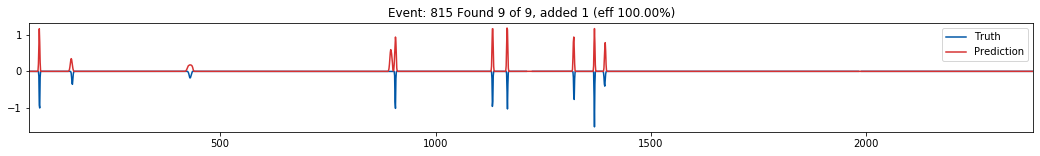

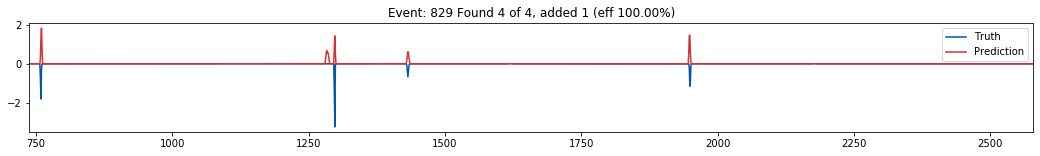

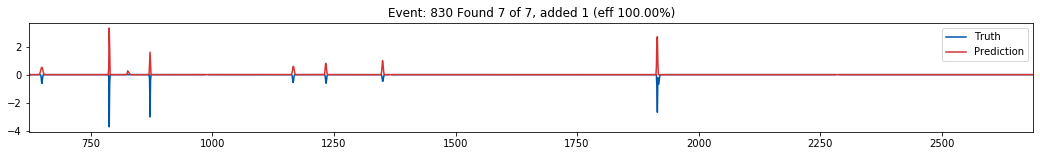

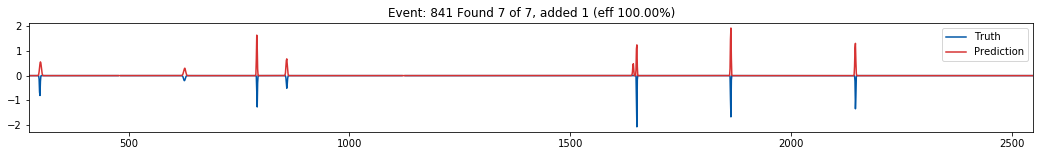

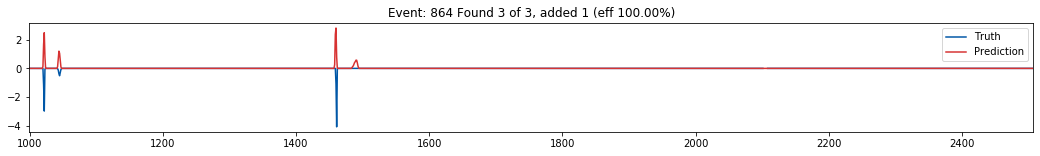

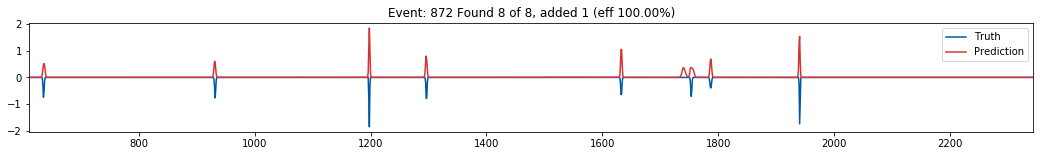

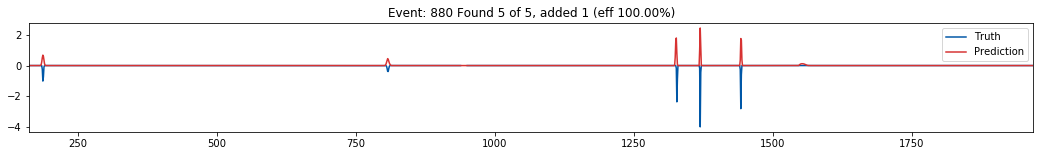

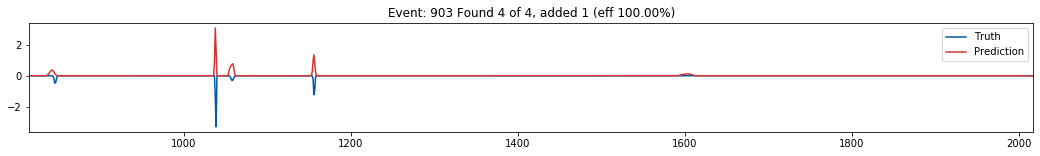

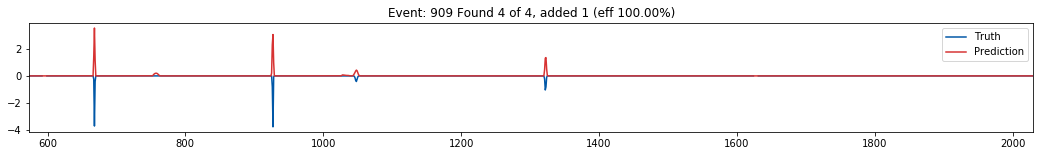

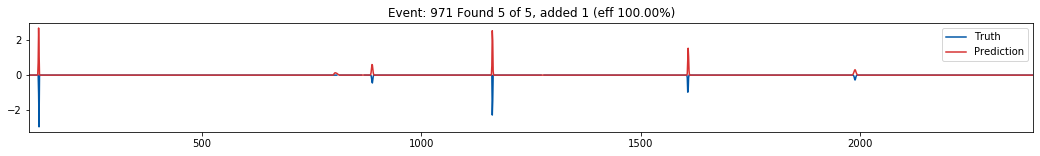

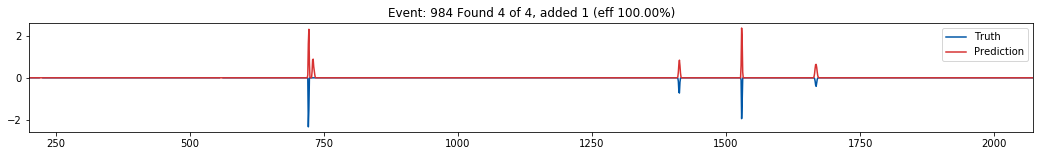

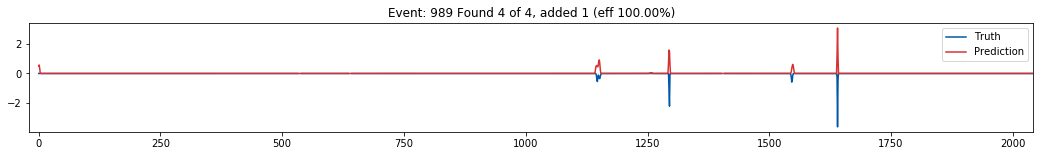

In [19]:
for i in range(1000):
    result = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res_top)
    if result.fp_rate>0 and result.eff_rate==1 :
        print(i)
        true_PVs_nTracks = truth_FullMC.n[i]
        true_PVs_z = truth_FullMC.z[i]
        sorted_true_PVs_z = [(i[0]+100)*10 for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
        sorted_true_PVs_n = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
        print(sorted_true_PVs_z)
        print(sorted_true_PVs_n)
        
        ax = plot_truth_vs_predict(labels_FullMC_mask[i], outputs_FullMC_mask[i])
        ax.set_title("Event: "+str(i)+" "+str(result))

#### Calculation using res(nTracks)

In [20]:
global_min_res = 3.0
eff_settings_res = dict(
    nsig_res = 5, # number of sigmas from original res(nTracks)
    min_res = global_min_res, # number of sigmas from original res(nTracks)
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3,    # bins
    debug = 1,    # bins
)
pv_loc_settings = dict(
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

total = ValueSet_res(0,0,0,0)
#total = efficiency_res(labels[0], outputs[0], truth.n[0], truth.z[0], **eff_settings_res)    
#print(total[4])
#total += efficiency_res(labels[1], outputs[1], truth.n[1], truth.z[1], **eff_settings_res) 
#efficiency_res(labels[0], outputs[0], truth.n[0], truth.z[0], **eff_settings_res) 

target_PVs_loc = pv_locations_res(labels_FullMC[0], **pv_loc_settings)
true_PVs_nTracks = truth_FullMC.n[0]
true_PVs_z = truth_FullMC.z[0]
nsig_res = 5.0
min_res = global_min_res
A_res = 926.0
B_res = 0.84
C_res = 10.7
filtered_and_sorted_res = np.empty_like(target_PVs_loc)

print(type(truth_FullMC.z[0][0]))


# #filtered_and_sorted_true_PVs_nTracks = np.zeros(len(true_PVs_z[true_PVs_nTracks > 4]), np.float32)
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
filtered_and_sorted_res = (nsig_res*0.01* (A_res / np.power(filtered_and_sorted_true_PVs_nTracks, -1 * B_res) + C_res))
get_resolution(target_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 1)
#print(get_resolution(pv_locations_res(labels[0], **pv_loc_settings), truth.n[0], truth.z[0], 5.0, global_min_res, 1))
# #get_nTracks_sorted(pv_locations_res(labels[0], **pv_loc_settings), truth.n[0], truth.z[0], 1)

<class 'numpy.float64'>
Sorted number of tracks (get_resolution):  [11, 62, 14, 12]


array([6.712477 , 3.       , 5.579678 , 6.2770734], dtype=float32)

In [21]:
total = ValueSet_res(0,0,0,0)
target_PVs_loc = pv_locations_res(labels_FullMC[0], **pv_loc_settings)
true_PVs_nTracks = truth_FullMC.n[0]
true_PVs_z = truth_FullMC.z[0]
nsig_res = 5.0
min_res = global_min_res
A_res = 926.0
B_res = 0.84
C_res = 10.7
filtered_and_sorted_res = np.empty_like(target_PVs_loc)


print(type(truth_ToyMC.z[0][0]))
print(type(truth_FullMC.z[0][0]))


# #filtered_and_sorted_true_PVs_nTracks = np.zeros(len(true_PVs_z[true_PVs_nTracks > 4]), np.float32)
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
filtered_and_sorted_res = (nsig_res*0.01* (A_res / np.power(filtered_and_sorted_true_PVs_nTracks, -1 * B_res) + C_res))
get_resolution(target_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 1)


<class 'numpy.float32'>
<class 'numpy.float64'>
Sorted number of tracks (get_resolution):  [11, 62, 14, 12]


array([6.712477 , 3.       , 5.579678 , 6.2770734], dtype=float32)

In [22]:

global_min_res = 0.0
for i in range(0,10):
    global_nsig_res = 2.0+0.5*i

    eff_settings_res_debug = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3,    # bins
        debug = 1,    # bins
    )
    eff_settings_res = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3, # bins
        debug = 0,     # bins
    )
    PV_found_settings_res = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3,    # bins
        debug = 0    # bins
    )

    big_total = ValueSet_res(0,0,0,0)

    
    res_all = np.ndarray(0,dtype=float)
    for label, output, ns, zs in zip(labels_FullMC, outputs_FullMC, truth_FullMC.n, truth_FullMC.z):
        #print(efficiency_res(label, output, ns, zs, **eff_settings_res))
        big_total += efficiency_res(label, output, ns, zs, **eff_settings_res) 
        pv_loc = pv_locations_res(label, **pv_loc_settings)
        res = get_resolution(pv_loc, ns, zs,global_nsig_res,global_min_res,0)
        res_all = np.append(res_all, res)
    #print(total)
    #print(big_total)
    print(f'For {global_nsig_res:.3} sigma resolution (mean = {np.mean(res_all):.3}, std = {np.std(res_all):.3} bins) => eff {big_total.eff_rate:.2%}, FP rate: {big_total.fp_rate:.3}/event')



For 2.0 sigma resolution (mean = 1.63, std = 0.926 bins) => eff 89.62%, FP rate: 0.716/event
For 2.5 sigma resolution (mean = 2.04, std = 1.16 bins) => eff 92.63%, FP rate: 0.561/event
For 3.0 sigma resolution (mean = 2.45, std = 1.39 bins) => eff 94.32%, FP rate: 0.474/event
For 3.5 sigma resolution (mean = 2.86, std = 1.62 bins) => eff 95.41%, FP rate: 0.418/event
For 4.0 sigma resolution (mean = 3.27, std = 1.85 bins) => eff 96.09%, FP rate: 0.383/event
For 4.5 sigma resolution (mean = 3.68, std = 2.08 bins) => eff 96.59%, FP rate: 0.357/event
For 5.0 sigma resolution (mean = 4.09, std = 2.31 bins) => eff 96.93%, FP rate: 0.34/event
For 5.5 sigma resolution (mean = 4.5, std = 2.55 bins) => eff 97.19%, FP rate: 0.327/event
For 6.0 sigma resolution (mean = 4.9, std = 2.78 bins) => eff 97.41%, FP rate: 0.315/event
For 6.5 sigma resolution (mean = 5.31, std = 3.01 bins) => eff 97.57%, FP rate: 0.307/event


In [23]:
for i in range(0,10):
    global_diff = 1.0*i

    eff_settings_loop = dict(
        difference = global_diff, # arr_totalsbins
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3    # bins
    )

    total_loop = ValueSet(0,0,0,0)
    for label, output in zip(labels_FullMC, outputs_FullMC):
        total_loop += efficiency(label, output, **eff_settings_loop)

    print(f'For {global_diff} bins resolution => eff {total_loop.eff_rate:.2%}, FP rate: {total_loop.fp_rate:.3}/event')


For 0.0 bins resolution => eff 0.01%, FP rate: 5.32/event
For 1.0 bins resolution => eff 81.36%, FP rate: 1.14/event
For 2.0 bins resolution => eff 92.68%, FP rate: 0.558/event
For 3.0 bins resolution => eff 95.78%, FP rate: 0.403/event
For 4.0 bins resolution => eff 97.18%, FP rate: 0.34/event
For 5.0 bins resolution => eff 97.92%, FP rate: 0.311/event
For 6.0 bins resolution => eff 98.32%, FP rate: 0.296/event
For 7.0 bins resolution => eff 98.58%, FP rate: 0.285/event
For 8.0 bins resolution => eff 98.74%, FP rate: 0.276/event
For 9.0 bins resolution => eff 98.87%, FP rate: 0.269/event


In [24]:
print(pv_locations(labels_FullMC[0], **eff_settings_nodiff)/10-100)
print(pv_locations_res(labels_FullMC[0], **eff_settings_nodiff)/10-100)
valid = truth_FullMC.n[0] > 4
zs = truth_FullMC.z[0][valid]
print(np.sort(zs))

l = [0,1,0,1]
print(len(l))
print(sum(l))

[-50.145817  19.949768  23.399315  86.03845 ]
[-50.095818  19.999771  23.449318  86.088455]
[-50.0957  19.9998  23.4493  86.0906]
4
2


In [25]:
eff_settings_res = dict(
                        nsig_res = 5, # number of sigmas from original res(nTracks)
                        min_res = 0, # 
                        threshold = 1e-2,
                        integral_threshold = .5,
                        min_width = 0, # bins
                        debug = 0,     # bins
                        )

mytotal = ValueSet(0,0,0,0)
mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal = ValueSet(0,0,0,0)
grand_mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal_res_mask = ValueSet_res(0,0,0,0)
print("#####################")
print("##  WITH RESO CODE :")
print("#####################")

for i in range(1000):
    mytotal = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)
    mytotal_res = efficiency_res(labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    mytotal_res_mask = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    grand_mytotal += mytotal
    grand_mytotal_res += mytotal_res
    grand_mytotal_res_mask += mytotal_res_mask
    #if (mytotal.fp_rate != mytotal_res.fp_rate or mytotal.eff_rate != mytotal_res.eff_rate):
    #    print(">>>>>>>>>Event : ",i)
    #    print("Original code:",mytotal)
    #    print("Current  code:",mytotal_res)

print("Original code:",grand_mytotal)
print("Current code:",grand_mytotal_res)
print("Current code mask:",grand_mytotal_res_mask)


#####################
##  WITH RESO CODE :
#####################
Original code: Found 5056 of 5157, added 301 (eff 98.04%) (0.301 FP/event)
Current code: Found 5125 of 5267, added 184 (eff 97.30%) (0.184 FP/event)
Current code mask: Found 5123 of 5267, added 131 (eff 97.27%) (0.131 FP/event)


In [26]:
i=97
print(efficiency_res(labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res_debug))

Sorted number of tracks (get_resolution):  [25, 67, 28, 28, 39, 30]

pred_PVs_loc =  [ 184.39195  251.69768  889.5038  1255.156   1363.4711  1503.7395 ]
target_PVs_loc =  [ 184.53079  251.30798  889.505   1255.062   1363.934   1503.6796 ]
resolutions :  [4.7250333 2.4559412 4.35913   4.35913   3.4690123 4.152843 ]

len(pred_PVs_loc) = 6
len(target_PVs_loc) = 6


In len(pred_PVs_loc) >= len(target_PVs_loc)
pred_PVs_loc =  184.39195251464844
resolution =  4.72503662109375
min_val =  179.80575561523438
max_val =  189.25582885742188
succeed =  1
pred_PVs_loc =  251.6976776123047
resolution =  2.4559478759765625
min_val =  248.85203552246094
max_val =  253.76393127441406
succeed =  2
pred_PVs_loc =  889.5037841796875
resolution =  4.359130859375
min_val =  885.1458740234375
max_val =  893.8641357421875
succeed =  3
pred_PVs_loc =  1255.156005859375
resolution =  4.359130859375
min_val =  1250.702880859375
max_val =  1259.421142578125
succeed =  4
pred_PVs_loc =  1363.4710693359375
resolutio

In [27]:
i=97
print(truth_FullMC.n[i], 10*(truth_FullMC.z[i]+100))
pv_loc = pv_locations_res(labels_FullMC[i], **pv_loc_settings)
print(pv_loc)
res = get_resolution(pv_loc, truth_FullMC.n[i], truth_FullMC.z[i],global_nsig_res,global_min_res,0)
print(res)
nTks = get_nTracks_sorted(pv_loc, truth_FullMC.n[i], truth_FullMC.z[i],0)
print(nTks)
found_PV = get_PVs_label(0, labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **PV_found_settings_res)
print(found_PV)

[28  0  0 39 25 67 28 30] [1255.064 1716.02  1030.57  1363.934  184.531  251.289  889.505 1503.68 ]
[ 184.53079  251.30798  889.505   1255.062   1363.934   1503.6796 ]
[4.7250333 2.4559412 4.35913   4.35913   3.4690123 4.152843 ]
[25 67 28 28 39 30]
[1 1 1 1 1 1]


In [28]:
res_all = np.zeros(10,dtype=int)
res_all_test = np.zeros(10,dtype=int)
res_all_test[5]=1


print(res_all)
print(res_all_test)
print(res_all[res_all_test==1])


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]
[0]


In [29]:
pvs_successful = Counter()
pvs_failed = Counter()

total_PVs = 0
res_all = np.ndarray(0,dtype=float)
nTcks_all = np.ndarray(0,dtype=int)
pvs_found_all = np.ndarray(0,dtype=int)

i = 0
for label, output, ns, zs in zip(labels_FullMC, outputs_FullMC, truth_FullMC.n, truth_FullMC.z):
    pv_loc = pv_locations_res(label, **pv_loc_settings)
    res = get_resolution(pv_loc, ns, zs,global_nsig_res,global_min_res,0)
    res_all = np.append(res_all, res)
    n_Tks = get_nTracks_sorted(pv_loc, ns, zs,0)
    nTcks_all = np.append(nTcks_all, n_Tks)
    found_PV = get_PVs_label(0, label, output, ns, zs, **PV_found_settings_res)
    pvs_found_all = np.append(pvs_found_all, found_PV)
    j = 0
    for item in found_PV:
        if item != 0 and item != 1:
            print(i)
            print(j, item)
        
    for nTks, foundPV in zip(n_Tks, found_PV):
        if foundPV == 1:
            pvs_successful[nTks] += 1
        else:
            pvs_failed[nTks] += 1
        total_PVs += 1
    i += 1
    
print(pvs_successful)
print(pvs_failed)
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals
print(arr_eff[:61])
print(arr_totals[:61])

Counter({16: 2997, 15: 2957, 14: 2951, 13: 2894, 17: 2866, 12: 2768, 18: 2684, 11: 2587, 19: 2532, 20: 2518, 10: 2392, 21: 2348, 9: 2121, 22: 2111, 23: 1947, 8: 1914, 24: 1837, 7: 1741, 25: 1734, 26: 1666, 27: 1576, 6: 1432, 29: 1431, 28: 1410, 30: 1387, 31: 1376, 32: 1335, 35: 1248, 33: 1226, 5: 1217, 34: 1212, 36: 1136, 38: 1117, 37: 1112, 40: 1059, 39: 1028, 41: 1000, 42: 981, 43: 971, 44: 958, 45: 922, 49: 846, 46: 838, 47: 833, 54: 812, 51: 809, 50: 805, 48: 790, 53: 747, 52: 731, 56: 715, 57: 701, 58: 676, 55: 663, 60: 651, 61: 630, 59: 628, 63: 604, 62: 555, 65: 553, 66: 544, 68: 539, 64: 529, 67: 525, 69: 524, 70: 492, 72: 466, 71: 441, 73: 439, 74: 429, 75: 404, 77: 369, 81: 366, 80: 363, 76: 358, 78: 355, 79: 354, 85: 304, 83: 302, 86: 299, 82: 298, 84: 276, 87: 264, 89: 241, 88: 229, 90: 225, 91: 215, 92: 210, 93: 202, 94: 191, 97: 177, 95: 170, 96: 160, 99: 147, 98: 139, 100: 136, 101: 134, 104: 125, 102: 124, 105: 121, 103: 115, 107: 108, 109: 97, 108: 94, 112: 90, 111: 89

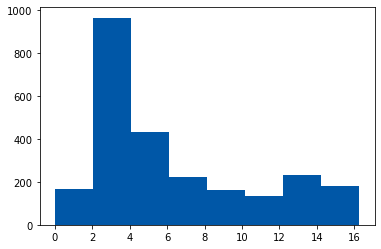

In [30]:
res_plot = plt.hist(res_all[pvs_found_all==0],bins=8)        
plt.show()

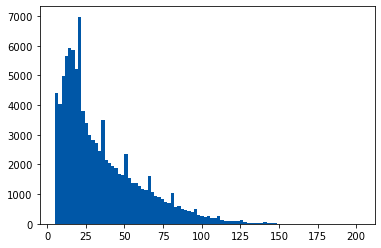

In [31]:
nTcks_plot = plt.hist(nTcks_all[pvs_found_all==1],bins=92)        
plt.show()

In [32]:
i = 0
for item in pvs_found_all:
    if item != 0 and item != 1:
        print(i, item)
    i+=1
#= plt.hist(pvs_found_all,bins=10)        
#plt.show()
print(nTcks_all[pvs_found_all==0])

[ 49  52  38 ...  39 118  59]


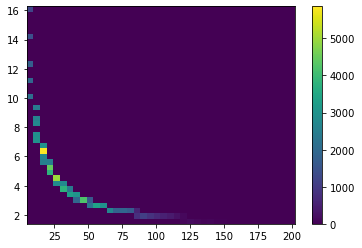

In [33]:
nTcks_res_plot = plt.hist2d(nTcks_all[pvs_found_all==1], res_all[pvs_found_all==1],bins=40)        
plt.colorbar()
plt.show()

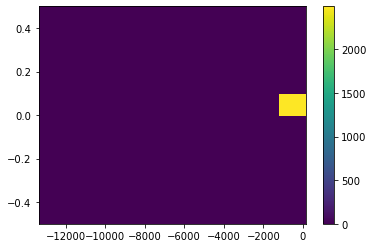

In [34]:
nTcks_res_plot = plt.hist2d(nTcks_all[pvs_found_all==0], pvs_found_all[pvs_found_all==0],bins=10)        
plt.colorbar()
plt.show()

In [35]:
i = 2

print(efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings))

found_values = pv_locations(outputs_FullMC[i], **eff_settings_nodiff)/10-100

valid = truth_FullMC.n[i] > 4
print(valid)
zs = truth_FullMC.z[i][valid]
ns = truth_FullMC.n[i][valid]

print("Found nTracks Location\tDistance")
for z,n in zip(zs, ns):
    closest = np.min(np.abs(z - found_values))
    found = closest < eff_settings['difference']/10
    print(f"{found!s:5} {n:7} {z:8.5}  {closest:8.5}")
    
target_values = pv_locations(labels_FullMC[i], **eff_settings_nodiff)/10-100
target_values

Found 5 of 5, added 2 (eff 100.00%)
[False  True False False  True False  True  True  True  True]
Found nTracks Location	Distance
True      104   127.89  0.039726
True       36   58.404   0.36123
True       16   14.556  0.0061522
True       13  -35.123  0.014683
True       26   52.929  0.054699
True       41   114.41  0.062256


array([-35.1736  ,  14.507225,  52.878952,  58.3544  , 114.3638  ],
      dtype=float32)

In [36]:
for i in range(100):

    eff = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)

    found_values = pv_locations(outputs_FullMC[i], **eff_settings_nodiff)/10-100

    valid = truth_FullMC.n[i] > 4
    zs = truth_FullMC.z[i][valid]
    ns = truth_FullMC.n[i][valid]

    total_found = 0
    for z,n in zip(zs, ns):
        closest = np.min(np.abs(z - found_values))
        found = closest < eff_settings['difference']/10
        total_found += found
        
    if total_found != eff.S:
        print(i, total_found, eff.S)

2 6 5
6 5 4
25 6 5
28 4 3
34 9 8
37 6 5
50 5 4
54 7 6
68 4 3
72 4 3
82 7 6
86 7 6
94 6 5


In [37]:
total_found, pvs_successful, pvs_failed = exact_efficiency(truth_FullMC, outputs_FullMC, **eff_settings)

In [38]:
print(pvs_failed.values())

dict_values([40419, 1116, 254, 9, 370, 172, 276, 136, 1337, 679, 296, 52, 339, 363, 448, 183, 323, 542, 92, 214, 10, 822, 93, 123, 105, 37, 78, 28, 1, 74, 45, 157, 9, 117, 98, 38, 67, 41, 459, 62, 346, 44, 171, 44, 103, 20, 121, 80, 62, 15, 223, 25, 244, 37, 86, 41, 65, 65, 43, 57, 60, 67, 66, 22, 54, 14, 16, 86, 43, 12, 19, 27, 27, 21, 9, 5, 26, 32, 51, 2, 34, 30, 2, 11, 30, 48, 3, 22, 3, 19, 34, 14, 6, 2, 5, 11, 13, 1, 8, 9, 2, 11, 10, 2, 2, 1, 1, 4, 3, 2, 2, 2, 3, 8, 2, 1, 5, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1])


In [39]:
fr = (total_found - total.S) / ((total_found + total.S) / 2)
print(f'Fractional difference between the two methods: {fr:.2%}')

Fractional difference between the two methods: 200.00%


In [40]:
# Found 49507 of 54804, added 5570 (eff 90.33%) (0.557 FP/event)
print(big_total)
print(f'Found {total_found} of {big_total.real_pvs} (eff {total_found/big_total.real_pvs:.2%})')

Found 100301 of 102795, added 6140 (eff 97.57%) (0.307 FP/event)
Found 104192 of 102795 (eff 101.36%)


In [41]:
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])

In [42]:
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals

In [43]:
print(arr_eff[5:61])
#print(arr_totals[:61])

[0.6405835543766578 0.7287234042553191 0.7744209466263847
 0.8294172932330827 0.8432867429055485 0.8690386071158214
 0.887062937062937 0.9029508196721312 0.8928909952606635
 0.9147885149737573 0.9218701937865272 0.9265281541704306
 0.9292737075800824 0.9284041485446638 0.9354952414522383
 0.9388553146107359 0.9333593141075605 0.9336432797971259
 0.9376146788990826 0.9425907752698724 0.937467700258398
 0.9337641357027464 0.94 0.9380139152435167 0.936064556176288
 0.9439739413680782 0.939016393442623 0.9368131868131868
 0.9545454545454546 0.9402985074626866 0.9522451888809693 0.9312
 0.9369951534733441 0.9408945686900958 0.9554585152838428
 0.9421915444348576 0.9464285714285714 0.9403669724770642
 0.9420560747663551 0.9372623574144486 0.9492682926829268
 0.9543524416135881 0.9388412017167382 0.953514739229025
 0.9545454545454546 0.9543429844097996 0.9272930648769575
 0.9470517448856799 0.9438596491228071 0.9413680781758957
 0.9506666666666667 0.9431818181818182 0.9534591194968554
 0.9409

In [44]:
np.savetxt('talks/arr_eff_sym.txt', arr_eff)
np.savetxt('talks/arr_totals_sym.txt', arr_totals)
import pickle
pickle.dumps(total)

b'\x80\x03cmodel.efficiency_res\nValueSet_res\nq\x00(K\x00K\x00K\x00K\x00tq\x01\x81q\x02.'

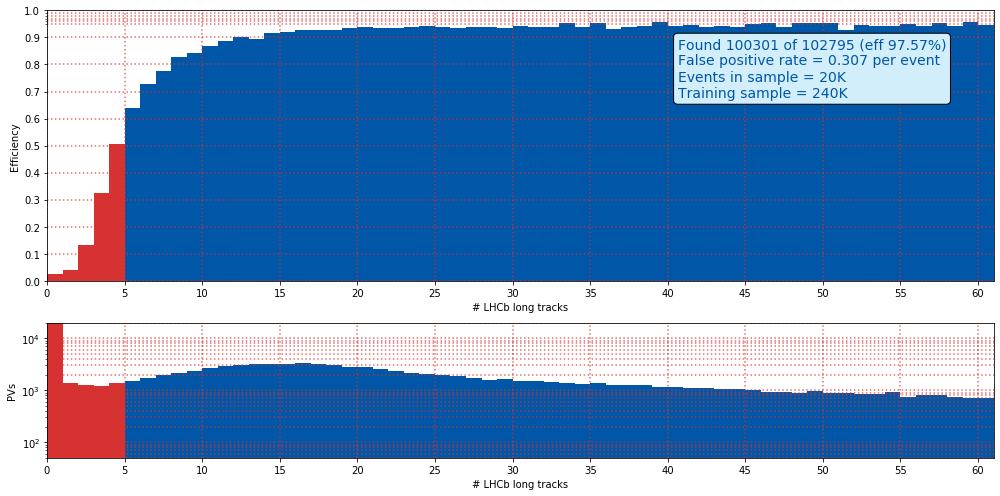

In [45]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,7), gridspec_kw={'height_ratios':(2,1)})

ax1.bar(np.arange(5,61), arr_eff[5:61], width=1, align='edge')
ax1.bar(np.arange(5), arr_eff[:5], width=1, align='edge')
ax1.set_xlabel('# LHCb long tracks')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(0,1.0)
ax1.set_xlim(0,61)
ax1.set_yticks(np.arange(11)/10)
ax1.set_yticks([.95,.96,.97,.98,.99],minor=True)
ax1.set_xticks(np.arange(0,61,5))
ax1.grid(which='both')

ax2.bar(np.arange(5,61), arr_totals[5:61], width=1, align='edge')
ax2.bar(np.arange(5), arr_totals[:5], width=1, align='edge')
ax2.set_xlabel('# LHCb long tracks')
ax2.set_ylabel('PVs')
ax2.set_xlim(0,61)
ax2.set_ylim(50,20000)
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0,61,5))
ax2.grid(which='both')

# these are matplotlib.patch.Patch properties
# total_found could be used instead of total.S
props = dict(boxstyle='round', facecolor='C2')
textprops = dict(color='C0', multialignment='left')
textstr = f'''\
Found {big_total.S} of {big_total.real_pvs} (eff {big_total.S/big_total.real_pvs:.2%})
False positive rate = {big_total.fp_rate:.3} per event
Events in sample = 20K
Training sample = 240K'''

# place a text box in upper left in axes coords
ax1.text(0.95, 0.9, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props, fontdict=textprops)

plt.tight_layout()
#plt.savefig('effntracks.pdf')
plt.show()

In [46]:
from numpy import random
from math import *

In [47]:
print("#####################")
print("##  WITH RESO CODE :")
print("#####################")

#####################
##  WITH RESO CODE :
#####################


In [48]:


eff_settings_res = dict(
                        nsig_res = 5, # number of sigmas from original res(nTracks)
                        min_res = 10.0, # 
                        threshold = 0.06,
                        integral_threshold = 0.75,
                        min_width = 0, # bins
                        debug = 0,     # bins
                        )


mytotal = ValueSet(0,0,0,0)
mytotal_res = ValueSet_res(0,0,0,0)
mytotal_res_mask = ValueSet_res(0,0,0,0)
grand_mytotal = ValueSet(0,0,0,0)
grand_mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal_res_mask = ValueSet_res(0,0,0,0)
for i in range(1000):
    mytotal = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)
    mytotal_res = efficiency_res(labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    mytotal_res_mask = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    grand_mytotal += mytotal
    grand_mytotal_res += mytotal_res
    grand_mytotal_res_mask += mytotal_res_mask
    #if (mytotal.fp_rate != mytotal_res.fp_rate or mytotal.eff_rate != mytotal_res.eff_rate):
    #    print(">>>>>>>>>Event : ",i)
    #    print("Original code:",mytotal)
    #    print("Current  code:",mytotal_res)

print("Original code:",grand_mytotal)
print("Current code:",grand_mytotal_res)
print("Current code mask:",grand_mytotal_res_mask)
grand_mytotal_res_mask.fp_rate
grand_mytotal_res_mask.eff_rate


Original code: Found 5056 of 5157, added 301 (eff 98.04%) (0.301 FP/event)
Current code: Found 5176 of 5281, added 119 (eff 98.01%) (0.119 FP/event)
Current code mask: Found 5174 of 5281, added 74 (eff 97.97%) (0.074 FP/event)


0.9797386858549517

In [49]:

min_widths = [0]
threshold_pow = -4*random.random(size=(40))
thresholds = sorted(0.1*10**threshold_pow)
thresholds
integral_thresholds = sorted(random.randint(150,size=(40))/1000)
integral_thresholds

print(min_widths)
print(thresholds)
print(integral_thresholds)

d_res={}
for i_min_width in min_widths:
    d_res[i_min_width]={}
    print('min_width',i_min_width)
    for i_threshold in thresholds:
        d_res[i_min_width][i_threshold]={}
        #print('   threshold',i_threshold)
        for i_integral_threshold in integral_thresholds:
            #print('      integral_threshold',i_integral_threshold)
            total = ValueSet_res(0,0,0,0)
            sum_total = ValueSet_res(0,0,0,0)
            for i in range(1000):
                #eff_settings_res = dict(nsig_res = 5,  min_res = 0.01, threshold = i_threshold, 
                #                        integral_threshold = i_integral_threshold, 
                #                        min_width = i_min_width, debug = 0,)

                total = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], 
                                       truth_FullMC.n[i], truth_FullMC.z[i], nsig_res = 5,  
                                       min_res = 0.01, threshold = i_threshold, 
                                       integral_threshold = i_integral_threshold, 
                                       min_width = i_min_width, debug = 0)    
                sum_total += total
            d_res[i_min_width][i_threshold][i_integral_threshold]={"eff":sum_total.eff_rate,"fp":sum_total.fp_rate}

[0]
[1.1820365651437377e-05, 1.9033462643356028e-05, 2.4395636578421648e-05, 2.4601431318559306e-05, 3.330426926599085e-05, 3.486477255559119e-05, 4.065479122342775e-05, 4.520553524121086e-05, 4.931534685651573e-05, 6.910749955933854e-05, 7.278216314754839e-05, 7.594850239012445e-05, 7.944529970322107e-05, 9.754030798601487e-05, 0.00012767996188701685, 0.00017241078490239645, 0.0001856365075621985, 0.00019199390455173275, 0.0002960852354900719, 0.00048492965581619046, 0.0005471185340145212, 0.0007905342616216114, 0.0007937218396749803, 0.0011546545493541164, 0.0017388252699446017, 0.002090575671429119, 0.0022414001669378487, 0.0024339325233826655, 0.004876452162403292, 0.007084222620207333, 0.009987448368233379, 0.013362432363590119, 0.014610512076204432, 0.01566977879931784, 0.026681207551012477, 0.03401908393251153, 0.041686335864841405, 0.04504252500998611, 0.07612387384695452, 0.07747486521742272]
[0.001, 0.003, 0.02, 0.024, 0.025, 0.027, 0.031, 0.038, 0.041, 0.042, 0.043, 0.044, 0

In [50]:
max_eff = 0
min_fp = 1
best_min_width=0
best_threshold=0
best_integral_threshold=0

for i_min_width in min_widths:
    for i_threshold in thresholds:
        for i_integral_threshold in integral_thresholds:
            eff = d_res[i_min_width][i_threshold][i_integral_threshold]["eff"]
            fp = d_res[i_min_width][i_threshold][i_integral_threshold]["fp"]
            #if eff>=max_eff and fp<=min_fp:
            if (eff - fp)>(max_eff - min_fp):
                max_eff=eff
                min_fp=fp
                best_min_width = i_min_width
                best_threshold = i_threshold
                best_integral_threshold = i_integral_threshold
                
print(max_eff,min_fp)
print(best_min_width,best_threshold,best_integral_threshold)


0.9734948882998864 0.137
0 0.07747486521742272 0.108
